##**Disclaimer**
These are the materials I used for this project:\
**[1]Pavia University Deep Learning**

`06_Attention_and_Transformers_in_BERT.ipynb`\
Multi Head Attention, Encoder Block, Bert Embeddings, Bert

**[2]Pavia University Machine Learning**

`English_to_italian_automatic_translation.ipynb`\
Dataset([Tatoeba Project](https://www.manythings.org/anki/)).For applying this dataset into Bert and GPT2, I removed `<sos>` token and `<eos>` token.\
In transformer, Tokenizer automatically add these token.

**[3]Hugging face**

Tokenizer `bert-base-cased` (English), MarianTokenizer `Helsinki-NLP/opus-mt-en-it`(Italian)

**[4]BLEU(Bilingual Evaluation Understudy) score**

this metrics is 0-1 scoring depend on the similarity of Source Language and Target Language.\
nltk.translate.bleu_score `sentence_bleu, SmoothingFunction`

**[5]Pytorch**

In pytorch, Weight of Neural Networks are automatically initialized: I did not use any other configuration but with default settings.


**My Implementation**:

- `Cross Head Attention` (Modify `Multi head Attention` (Self Attention))
- `BERT2GPT` (This idea is common, but I reimplemented wheel)
- `Translation Dataset`
- `Learning Phase`, `Inference Phase`
- `Bert Embedding Visualization` (Based on my Word2Vec Visualization implementation)


Bert Implementation - This was implemented by Naoya Kumakura with refering to [1]

In [ ]:
### This code is based on [1] Deep Learning, but some part is modified by Naoya Kumakura(Me).
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import transformers
class MultiHeadAttention(nn.Module):
    """
    - Query, Key, Value
    - Scaled Dot Product Attention: softmax(QK^T / sqrt(d_k))V
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.dropout = torch.nn.Dropout(dropout)

        # Q, K, V linear Conversion
        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)

        self.out_proj = torch.nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape

        # step1: Q, K, V
        query = self.query(x)  # (batch, seq_len, d_model)
        key = self.key(x)      # (batch, seq_len, d_model)
        value = self.value(x)  # (batch, seq_len, d_model)

        # step2: Multi-Head
        query = query.view(batch_size, seq_len, self.num_heads, self.head_dim)
        key = key.view(batch_size, seq_len, self.num_heads, self.head_dim)
        value = value.view(batch_size, seq_len, self.num_heads, self.head_dim)

        # step3: Change Dimention for Calclate Efficiently
        query = query.permute(0, 2, 1, 3)  # (batch, num_heads, seq_len, head_dim)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        # step4: Scaled Dot-Product Attention
        # scores = Q @ K^T / sqrt(d_k)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # step5: masking
        if mask is not None:
            scores = scores + mask

        # step6: Softmax + Dropout
        weights = F.softmax(scores, dim=-1)  # (batch, num_heads, seq_len, seq_len)
        weights = self.dropout(weights)
        # step7: multiply with Value
        context = torch.matmul(weights, value)
        # step8: Restore the original shape of tensor
        context = context.permute(0, 2, 1, 3)
        # → (batch, seq_len, d_model)
        context = context.contiguous().view(batch_size, seq_len, self.num_heads * self.head_dim)

        # Step9: Final Linear Conversion
        return self.out_proj(context)  # 修正: output_linear → out_proj

class PositionwiseFeedForward(nn.Module):
    """
    Property:
    - 2 layer Neural Network
    - 中間層では次元を拡張（通常4倍）Based on the paper, Hidden Layer has 4 times bigger dimention
    - GELU is used (It has Effect of Regularization to some Extent)
    - Drop out (Regularization)
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)  # 入力次元 → 中間次元
        self.linear2 = nn.Linear(d_ff, d_model)  # 中間次元
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

class EncoderBlock(nn.Module):
    """
    - Multi-Head Attention + Residual Connection + Layer Norm
    - Feed Forward + Residual Connection + Layer Norm
    - Which is better??: Pre-LN vs Post-LN - Pre-LN
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model,num_heads)
        self.ffn = PositionwiseFeedForward(d_model,d_ff)

        self.layer_norm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layer_norm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        #Attention block
        #TODO implement transformer block
        residual = x
        #print("Took Residual...",x.shape)
        x = self.layer_norm1(x)
        #print("calculating layer norm...",x.shape)
        x = self.dropout(self.attention(x,mask))
        #print("calculating Attention...",x.shape)
        x = x + residual
        #print("calculating Residual Connection...",x.shape)
        #ffnn
        residual = x
        x = self.layer_norm2(x)
        #print("calculating layer norm...",x.shape)
        x = self.dropout(self.ffn(x))
        #print("calculating ffn...",x.shape)
        x = x + residual
        return x


class BertEmbeddings(nn.Module):
    """
    - Token Embeddings (Vocabsize × d_model)
    - Position Embeddings (Maximum Sequence length × d_model)
    - Segment Embeddings (2 × d_model, NSP Task)
    - Add three types of embedding, LayerNorm and Dropout
    """
    def __init__(self, vocab_size, d_model, max_seq_len=512, dropout=0.1):
        super().__init__()
        # TODO: 3種類の埋め込みを実装
        self.d_model = d_model
        self.token = torch.nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.position = torch.nn.Embedding(max_seq_len, d_model)
        self.segment = torch.nn.Embedding(2, d_model)  # 2つのセグメント（0と1）
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        #Embedding: Lookup table that keep meaning vector of words
    def forward(self, input_ids, token_type_ids=None):
        # TODO: 埋め込みの計算を実装
        batch_size, seq_len = input_ids.shape
        # Step 1: Token Embeddings
        token_embeddings = self.token(input_ids)
        # Step 2: Position Embeddings
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        position_ids = position_ids.expand(batch_size, -1)  # 🔧 バッチ次元を拡張
        position_embeddings = self.position(position_ids)
        # Step 3: Segment Embeddings
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)  # 全て0（単一文）
        segment_embeddings = self.segment(token_type_ids)  # (batch, seq_len, d_model)
        embeddings = token_embeddings + position_embeddings + segment_embeddings
        embeddings = self.dropout(self.layer_norm(embeddings))

        return embeddings

class Bert(nn.Module):
    def __init__(self, vocab_size, d_model=768, num_layers=12, num_heads=12, d_ff=3072, max_seq_len=512, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.heads = num_heads
        # paper noted 4*d_model size for ff
        self.feed_forward_hidden = d_model * 4
        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BertEmbeddings(vocab_size, d_model, max_seq_len, dropout)

        self.encoder_blocks = torch.nn.ModuleList(
            [EncoderBlock(d_model, num_heads, d_model * 4, dropout) for _ in range(num_layers)])

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Implement All BERT forward pass
        if attention_mask is None:
            attention_mask = (input_ids != 0).float()
        if attention_mask.dim() == 2:
            # (batch, seq_len) → (batch, 1, 1, seq_len)
            extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            # print("squeeze is required")
        elif attention_mask.dim() == 4:
            # If it has correct shape, just use it
            extended_attention_mask = attention_mask
            # print("squeeze is not required")
        else:
             raise ValueError(f"Attention mask should be 2D or 4D, but got {attention_mask.dim()}D")

        # Convert attention mask (0) into -1e9（to make it 0 in Softmax）
        extended_attention_mask = (1.0 - extended_attention_mask) * -1e9


        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(input_ids, token_type_ids)
        # running over multiple transformer blocks
        for encoder in self.encoder_blocks:
            x = encoder.forward(x, extended_attention_mask)
        return x


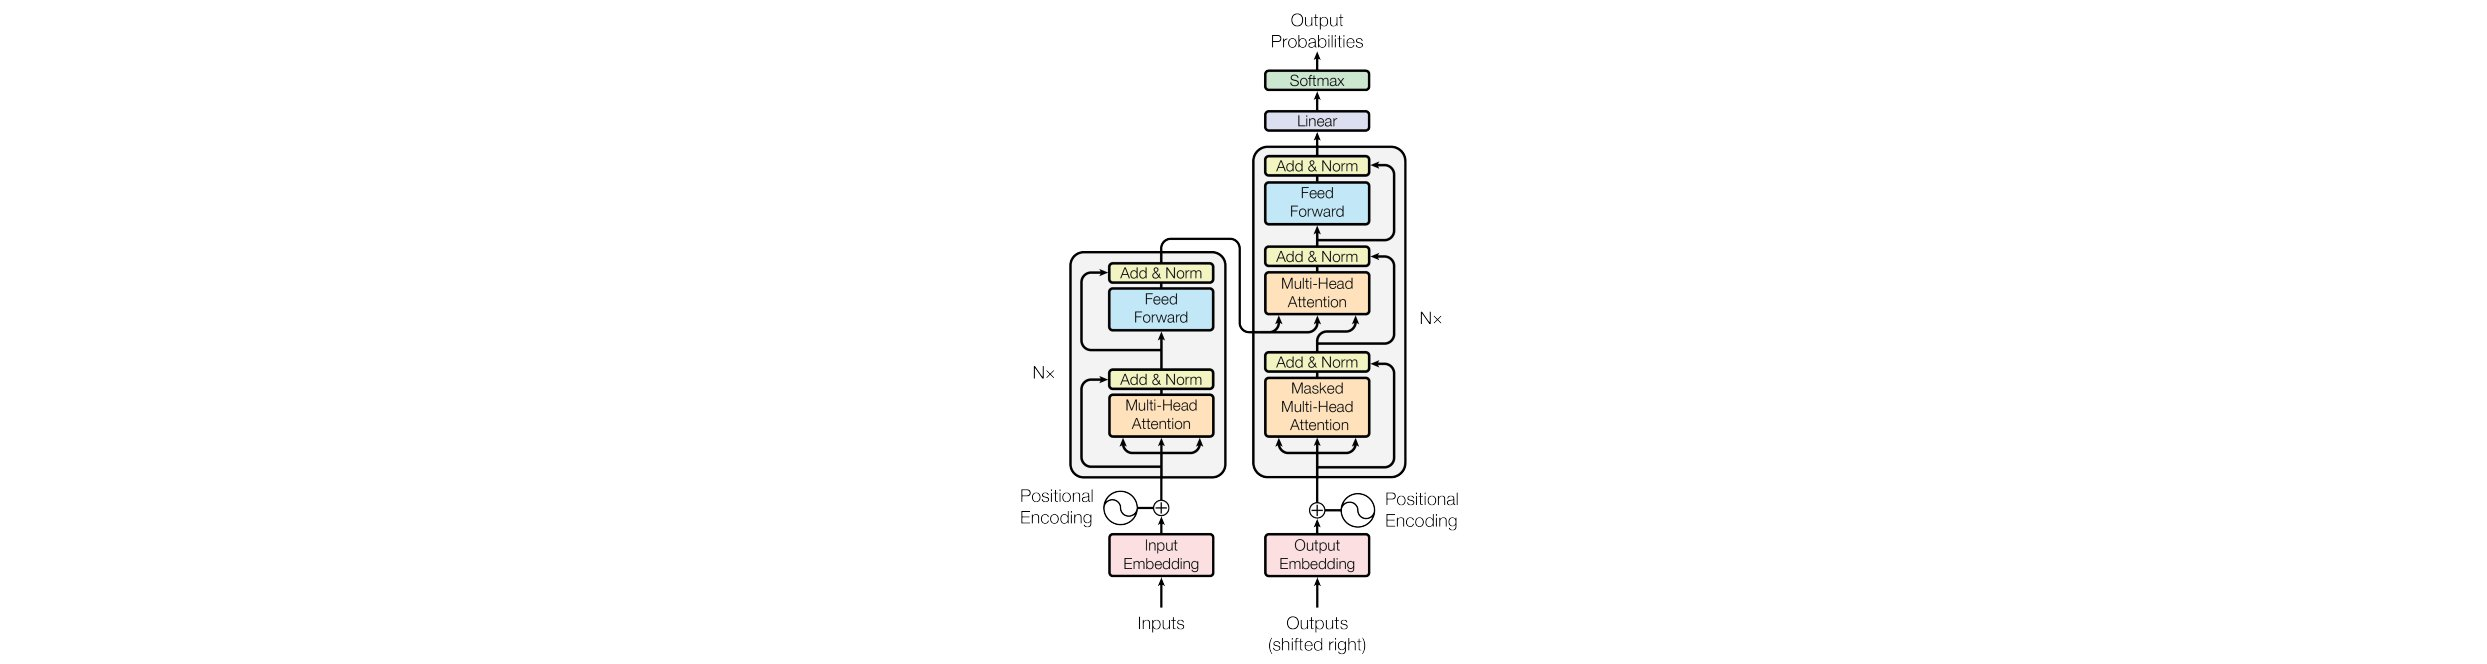
https://arxiv.org/abs/1706.03762

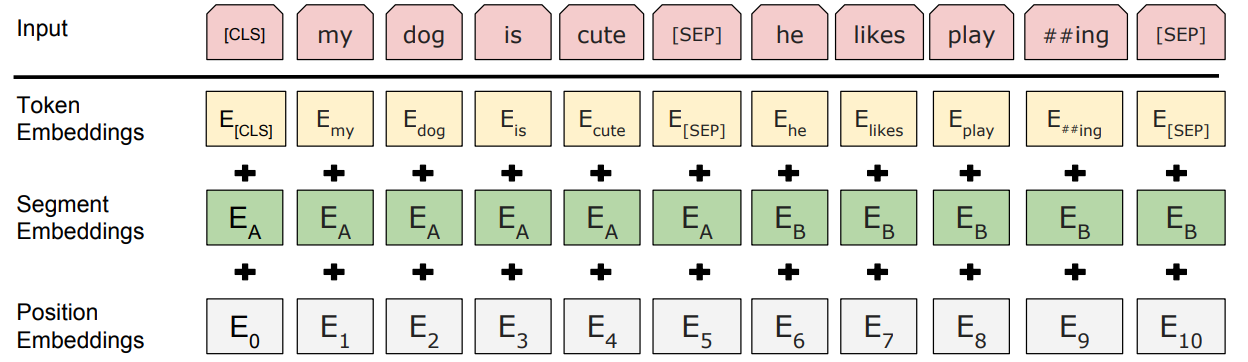
https://arxiv.org/pdf/1810.04805

## Bert embedding vs GPT Embedding
Bert/GPT Embedding is quite similar, but about Positional Embedding, there's significant difference:
### position embedding

- Bert embedding : Learnable Positional Embedding
- GPT embedding : Definetive Positional Embedding

This allows Bert to understand scentence more profoundly, but takes time to learn properly.

GPT embedding is generally useful. Although the length of input is longer than expected, It is possible to handle it.

$$
p_{i,2j}=sin(\frac{i}{s^{2j/d}})
$$

$$
p_{i,2j+1}=cos(\frac{i}{s^{2j/d}})
$$

In [ ]:
### This cell is my Implementation
class CrossAttention(nn.Module):
    """
    this module is implemented with modifying MultiHeadAttention.
    Query: English
    Key, Value: Italian
    You can see the difference in forward input
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__() # initialization
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads  # dimention of each head
        self.dropout = torch.nn.Dropout(dropout)

        # Linear transformation of Q, K, V
        self.query = torch.nn.Linear(d_model, d_model)
        self.key = torch.nn.Linear(d_model, d_model)
        self.value = torch.nn.Linear(d_model, d_model)

        # Final Linear transformation
        self.out_proj = torch.nn.Linear(d_model, d_model)

    def forward(self, query_input, key_value_input, mask=None, return_attention=False):
        batch_size, q_len, _ = query_input.shape
        _, kv_len, _ = key_value_input.shape

        # Q, K, V Linear Transformation
        query = self.query(query_input)
        key = self.key(key_value_input)
        value = self.value(key_value_input)

        # Reshape for Multi-head
        query = query.view(batch_size, q_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        key = key.view(batch_size, kv_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        value = value.view(batch_size, kv_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Score of Attentin
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # Mask Application
        if mask is not None:
            scores = scores + mask

        # Softmax → Attention Weights
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Value
        context = torch.matmul(attn_weights, value)
        context = context.permute(0, 2, 1, 3).contiguous().view(batch_size, q_len, self.d_model)

        # output Linear
        out = self.out_proj(context)

        if return_attention:
            return out, attn_weights
        return out

class GPT2DecoderBlockWithCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = CrossAttention(d_model, num_heads, dropout)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, self_attn_mask=None, cross_attn_mask=None, return_attention=False):
        # Self Attention
        residual = x
        x = self.ln1(x)
        x = self.self_attn(x, mask=self_attn_mask)
        x = self.dropout(x) + residual

        # Cross Attention
        residual = x
        x = self.ln2(x)
        if return_attention:
            x_attended, cross_attn_weights = self.cross_attn(x, encoder_output, mask=cross_attn_mask, return_attention=True)
        else:
            x_attended = self.cross_attn(x, encoder_output, mask=cross_attn_mask)
            cross_attn_weights = None
        x = self.dropout(x_attended) + residual

        # FFN
        residual = x
        x = self.ln3(x)
        x = self.ffn(x)
        x = self.dropout(x) + residual

        return (x, cross_attn_weights) if return_attention else x


class BERT2GPT(nn.Module):
    def __init__(self, encoder: Bert, decoder_layers=6, d_model=768, num_heads=12, d_ff=3072, vocab_size=50257):
        super().__init__()
        self.encoder = encoder
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_blocks = nn.ModuleList([
            GPT2DecoderBlockWithCrossAttention(d_model, num_heads, d_ff) for _ in range(decoder_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, src_input_ids, tgt_input_ids, src_attention_mask=None, tgt_attention_mask=None, return_attention=False):
        encoder_output = self.encoder(src_input_ids, attention_mask=src_attention_mask)
        tgt_embeddings = self.decoder_embedding(tgt_input_ids)

        batch_size, tgt_len = tgt_input_ids.size()
        device = tgt_input_ids.device
        causal_mask = torch.tril(torch.ones(tgt_len, tgt_len, device=device)).unsqueeze(0).unsqueeze(1)
        causal_mask = (1.0 - causal_mask) * -1e9

        x = tgt_embeddings
        cross_attn_weights_all = []

        for i, block in enumerate(self.decoder_blocks):
            if return_attention and i == len(self.decoder_blocks) - 1:  # 最終層だけでOK
                x, attn_weights = block(x, encoder_output, self_attn_mask=causal_mask, return_attention=True)
                cross_attn_weights_all.append(attn_weights)
            else:
                x = block(x, encoder_output, self_attn_mask=causal_mask)

        x = self.ln_f(x)
        logits = self.output_proj(x)

        if return_attention:
            return logits, cross_attn_weights_all[0]  # (B, heads, tgt_len, src_len)
        else:
            return logits



In [ ]:
#Execute 1 time
### Suppress useless warnings
import warnings
warnings.filterwarnings("ignore", message="The secret `HF_TOKEN` does not exist")
from collections import defaultdict
from transformers import AutoTokenizer, MarianTokenizer

# Download the files, Execute Once
URL = "https://drive.google.com/file/d/1_npGYZk13fs5hE0kAggiSrmKkqW3OrLT/view?usp=sharing"
!gdown --fuzzy $URL -O- | tar -xz
### based on [1] Deep Learning
src_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")  # English
### I choosed token for this project
tgt_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-it")
"""
# I should have done with my original tokenizer, because I implemented my model and these pretrained tokenizer would be not apropriate.
from tokenizers import ByteLevelBPETokenizer
src_tokenizer = ByteLevelBPETokenizer()
src_tokenizer.train(["eng_text.txt"], vocab_size=32000, min_frequency=2)
srctokenizer.save_model("src_tokenizer")
tgt_tokenizer = ByteLevelBPETokenizer()
tgt_tokenizer.train(["eng_text.txt"], vocab_size=32000, min_frequency=2)
tgttokenizer.save_model("tgt_tokenizer")
"""

Downloading...
From: https://drive.google.com/uc?id=1_npGYZk13fs5hE0kAggiSrmKkqW3OrLT
To: <_io.BufferedWriter name='<stdout>'>
100% 3.92M/3.92M [00:00<00:00, 22.2MB/s]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/789k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
### from [2]Machine Learning
def load_translation_pairs(eng_path, ita_path):
    with open(eng_path, "r") as f_eng, open(ita_path,"r") as f_ita:
        eng_lines = f_eng.read().replace('<sos>', '').replace('<eos>', '').strip().split("\n")
        ita_lines = f_ita.read().replace('<sos>', '').replace('<eos>', '').strip().split("\n")

    assert len(eng_lines) == len(ita_lines), "The line has missalignment"
    return list(zip(eng_lines, ita_lines))
pairs = load_translation_pairs("text-eng.txt", "text-ita.txt")
print(pairs[:5])

[('hi . ', 'ciao ! '), (' hi . ', ' ciao . '), (' run ! ', ' corri ! '), (' run ! ', ' corra ! '), (' run ! ', ' correte ! ')]


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class TranslationDataset(Dataset):
    def __init__(self, pairs, src_tokenizer, tgt_tokenizer, max_length=64):
        self.pairs = pairs
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src_text, tgt_text = self.pairs[idx]

        src_enc = self.src_tokenizer(
            src_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        tgt_enc = self.tgt_tokenizer(
            tgt_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "src_input_ids": src_enc["input_ids"].squeeze(0),
            "src_attention_mask": src_enc["attention_mask"].squeeze(0),
            "tgt_input_ids": tgt_enc["input_ids"].squeeze(0),
            "tgt_attention_mask": tgt_enc["attention_mask"].squeeze(0),
        }

train_pairs, val_pairs = train_test_split(pairs, test_size=0.1, random_state=42)

train_dataset = TranslationDataset(train_pairs, src_tokenizer, tgt_tokenizer, max_length=64)
val_dataset = TranslationDataset(val_pairs, src_tokenizer, tgt_tokenizer, max_length=64)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#dataset = TranslationDataset(pairs, src_tokenizer, tgt_tokenizer, max_length=64)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
from torch.optim import Adam
MAXLEN=20
src_vocab_size = len(src_tokenizer)
tgt_vocab_size = len(tgt_tokenizer)

encoder = Bert(vocab_size=src_vocab_size,
               d_model=768,
               num_layers=12,
               num_heads=12,
               d_ff=3072,
               max_seq_len=512,
               dropout=0.1
               ) # Instantiate the Bert encoder

model = BERT2GPT(encoder=encoder,
                 vocab_size=tgt_vocab_size,
                 decoder_layers=6,
                 d_model=768,
                 num_heads=12,
                 d_ff=3072,
                 )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

optimizer = Adam(model.parameters(), lr=5e-5)
pad_token_id = tgt_tokenizer.pad_token_id


cuda


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from google.colab import drive
import os
drive.mount('/content/drive')
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')
nltk.download('punkt_tab') # Download the missing resource
def save_checkpoint(model, optimizer, epoch, step, path_dir="/content/drive/MyDrive/checkpoints"):
    os.makedirs(path_dir, exist_ok=True)
    filename = f"checkpoint_epoch{epoch}_step{step}.pt"
    path = os.path.join(path_dir, filename)
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "step": step,
    }, path)
def find_latest_checkpoint(path_dir="/content/drive/MyDrive/checkpoints"):
    if not os.path.exists(path_dir):
        return None
    checkpoints = [f for f in os.listdir(path_dir) if f.startswith("checkpoint_epoch")]
    if not checkpoints:
        return None
    # ソートして最新のものを取得
    checkpoints = sorted(checkpoints, key=lambda x: (
        int(x.split("epoch")[1].split("_")[0]),  # epoch number
        int(x.split("step")[1].split(".")[0])    # step number
    ))
    return os.path.join(path_dir, checkpoints[-1])

def load_latest_checkpoint(model, optimizer=None, path_dir="/content/drive/MyDrive/checkpoints"):
    path = find_latest_checkpoint(path_dir)
    if path is None:
        print("The checkpoint not found. Start from scratch")
        return 0, 0
    # 修正: map_locationを指定してCPUで読み込む
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    print(f"Load First Checkpoint: {path}")
    return checkpoint["epoch"], checkpoint["step"]
"""
def load_checkpoint(model, optimizer, path="checkpoint.pt"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]
    start_step = checkpoint["step"]
    return start_epoch, start_step
"""
def compute_bleu(reference, prediction):
    ref_tokens = nltk.word_tokenize(reference.lower())
    pred_tokens = nltk.word_tokenize(prediction.lower())
    smoothie = SmoothingFunction().method4
    return sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)

from itertools import islice

def evaluate(model, val_dataloader, device, pad_token_id):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
    total_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            src_input_ids = batch["src_input_ids"].to(device)
            src_attention_mask = batch["src_attention_mask"].to(device)
            tgt_input_ids = batch["tgt_input_ids"].to(device)

            decoder_input = tgt_input_ids[:, :-1]
            labels = tgt_input_ids[:, 1:]

            logits = model(src_input_ids, decoder_input, src_attention_mask)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(val_dataloader)

def train(model, train_dataloader,val_dataloader, optimizer, device, pad_token_id, src_tokenizer, tgt_tokenizer, num_epochs=5, print_every=100):
    # チェックポイントから再開
    start_epoch, start_step = load_latest_checkpoint(model, optimizer, path_dir="/content/drive/MyDrive/checkpoints")
    print(f"Start from Check point: epoch={start_epoch}, step={start_step}")

    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
    # CrossEntropy + Softmax
    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0

        # start_step 分だけデータをスキップ
        data_iter = iter(train_dataloader)
        if epoch == start_epoch and start_step > 0:
            data_iter = islice(data_iter, start_step, None)

        # tqdm で進捗表示（表示stepは正しく設定）
        pbar = tqdm(
            enumerate(data_iter, start=start_step if epoch == start_epoch else 0),
            total=len(train_dataloader),
            initial=start_step if epoch == start_epoch else 0,
            desc=f"Epoch {epoch + 1}/{num_epochs}"
        )
        model.eval()
        val_loss = evaluate(model, val_dataloader, device, pad_token_id)
        print(f"Validation Loss (Epoch {epoch + 1}): {val_loss:.4f}")
        model.train()
        for step, batch in pbar:
            if step % 1000 == 0 and not (epoch == start_epoch and step == start_step):
                save_checkpoint(model, optimizer, epoch, step, path_dir="/content/drive/MyDrive/checkpoints")

            src_input_ids = batch["src_input_ids"].to(device)
            src_attention_mask = batch["src_attention_mask"].to(device)
            tgt_input_ids = batch["tgt_input_ids"].to(device)

            decoder_input = tgt_input_ids[:, :-1]
            labels = tgt_input_ids[:, 1:]
            # Model output: Probability Distribution
            logits = model(src_input_ids, decoder_input, src_attention_mask)
            ## criterion is Cross Enrtopy Loss.
            loss = criterion(logits.view(-1, logits.size(-1)), labels.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": loss.item()})

            if step % print_every == 0:
                model.eval()
                with torch.no_grad():
                    pred_ids = logits.argmax(-1)
                    for i in range(min(2, src_input_ids.size(0))):
                        src_text = src_tokenizer.decode(batch["src_input_ids"][i], skip_special_tokens=True)
                        tgt_text = tgt_tokenizer.decode(batch["tgt_input_ids"][i], skip_special_tokens=True)
                        pred_text = tgt_tokenizer.decode(pred_ids[i], skip_special_tokens=True)

                        bleu = compute_bleu(tgt_text, pred_text)

                        print("\n[Input]     ", src_text)
                        print("[Target]    ", tgt_text)
                        print("[Predicted] ", pred_text)
                        print("[BLEU]      ", f"{bleu:.4f}")

                model.train()

        # エポック末尾で checkpoint 保存
        save_checkpoint(model, optimizer, epoch, step, path_dir="/content/drive/MyDrive/checkpoints")

def greedy_decode(model, src_input_ids, src_attention_mask, tgt_tokenizer, max_len=50, device='cuda',return_attention=False):
    model.eval()
    batch_size = src_input_ids.size(0)

    bos_token_id = tgt_tokenizer.bos_token_id
    if bos_token_id is None:
        bos_token_id = tgt_tokenizer.pad_token_id

    decoder_input = torch.full((batch_size, 1), bos_token_id, dtype=torch.long).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            logits, cross_attn_weights = model(src_input_ids, decoder_input, src_attention_mask,return_attention=True)
            next_token = logits[:, -1, :].argmax(-1, keepdim=True)  # (batch, 1)
            decoder_input = torch.cat([decoder_input, next_token], dim=1)

            if (next_token == tgt_tokenizer.eos_token_id).all():
                break
    if return_attention == True:
        return decoder_input, cross_attn_weights
    return decoder_input


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Train Model
If you are not interested in Traning model, do not execute this part. this part will take you a lot of time.

In [ ]:
train(model=model, train_dataloader=train_dataloader,val_dataloader=val_dataloader, optimizer=optimizer, device=device, pad_token_id=pad_token_id, src_tokenizer=src_tokenizer,tgt_tokenizer=tgt_tokenizer,num_epochs=5)

✅ 最新のチェックポイントを読み込みました: /content/drive/MyDrive/checkpoints/checkpoint_epoch2_step6000.pt
✅ チェックポイントから再開: epoch=2, step=6000


Epoch 3/5:  64%|██████▍   | 6000/9369 [00:00<?, ?it/s]

🔍 Validation Loss (Epoch 3): 0.1848


Epoch 3/5:  64%|██████▍   | 6001/9369 [06:40<374:43:27, 400.54s/it, Loss=0.139]


[Input]      listen to tom.
[Target]     ascoltate tom .
[Predicted]  coltaate tom . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0111

[Input]      how can this work?
[Target]     come può funzionare questo ?
[Predicted]  può funzionare questo ? ?ooo ? ?o ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0414


Epoch 3/5:  65%|██████▌   | 6101/9369 [08:05<45:37,  1.19it/s, Loss=0.33]


[Input]      of course, i remember tom.
[Target]     certo , mi ricordo di tom .
[Predicted]  to , ri ricordo di tom . . . . . . . . . . . a . . . . . . . . . . . . . . . . . . a . . . . . . . . . . . con . . . . . . . a .
[BLEU]       0.0414

[Input]      i like cheese pizza.
[Target]     mi piace la pizza con il formaggio .
[Predicted]  piace la pizza . la formaggio . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0274


Epoch 3/5:  66%|██████▌   | 6201/9369 [09:30<44:47,  1.18it/s, Loss=0.181]


[Input]      i almost never make mistakes.
[Target]     non commetto quasi mai degli errori .
[Predicted]  fmetto quasi mai errori errori . . . . . . . . . error . . .o . . error . .o . error . . . . .o .o error . . . .oooo quasio erroro .o . . quasi . .ooo
[BLEU]       0.0205

[Input]      so what ' s your problem?
[Target]     allora , qual è il tuo problema ?
[Predicted]  ora qua, qual è il suo problema ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0474


Epoch 3/5:  67%|██████▋   | 6301/9369 [10:54<43:22,  1.18it/s, Loss=0.186]


[Input]      i live in a town near boston.
[Target]     io vivo in una città vicino a boston .
[Predicted]  a in una città vicino a boston . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.1006

[Input]      who knows what might happen?
[Target]     chi sa cosa potrebbe capitare ?
[Predicted]  sa chesa potrebbe sucre ? ?re ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? . ? ? ? ? ? ?
[BLEU]       0.0073


Epoch 3/5:  68%|██████▊   | 6401/9369 [12:19<42:01,  1.18it/s, Loss=0.32]


[Input]      meet me in the bar.
[Target]     incontriamoci al bar .
[Predicted]  contriamoci nel bar . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0111

[Input]      what ' re you saying?
[Target]     che cosa stai dicendo ?
[Predicted]  cosa stai dicendo ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0399


Epoch 3/5:  69%|██████▉   | 6501/9369 [13:44<40:35,  1.18it/s, Loss=0.244]


[Input]      we ' ll start as soon as it stops raining.
[Target]     cominceremo appena smette di piovere .
[Predicted]  inceremo appena smette di piovere .re . . . .siment . . . . . . . . . .ment . . . . . . . . . . . . . . . .ament . . . . . . . .siamentament .la . .
[BLEU]       0.0515

[Input]      i used to be fat.
[Target]     ero grassa .
[Predicted]  ero grassa . . . . . . . . . . . . . . . . . . . . . .si . . . . . . . . . . . . . . . . . . . . . . . . . . .si . . . . . . . .
[BLEU]       0.0218


Epoch 3/5:  70%|███████   | 6601/9369 [15:08<39:10,  1.18it/s, Loss=0.239]


[Input]      let ' s start with you.
[Target]     cominciamo con lei .
[Predicted]  inciamo con telei . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . con . . . . . . .
[BLEU]       0.0063

[Input]      i ' m coming early.
[Target]     verrò presto .
[Predicted]  rò presto . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .ò . .
[BLEU]       0.0113


Epoch 3/5:  72%|███████▏  | 6701/9369 [16:33<37:43,  1.18it/s, Loss=0.251]


[Input]      tom wrote something on the blackboard.
[Target]     tom ha scritto qualcosa sulla lavagna .
[Predicted]  m ha scritto qualcosa sulla lavagna . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0814

[Input]      i have to go to the bank now.
[Target]     io devo andare in banca ora .
[Predicted]  devo andare in banca aa . . a . or a a a a . a a a a . a a a a a a or a a a or a a a a a a a a a a a a a a a a a a a a a a a a a a a
[BLEU]       0.0414


Epoch 3/5:  73%|███████▎  | 6801/9369 [17:57<36:16,  1.18it/s, Loss=0.317]


[Input]      why did you need a chainsaw?
[Target]     perché le serviva una motosega ?
[Predicted]  ché a serviva una motosega ? at ?e ?e ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? . ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0399

[Input]      tom isn ' t like the others, is he?
[Target]     tom non è come gli altri , vero ?
[Predicted]  m non è come gli altri , vero ? ? ? ? ? ? ? ? ? ? ?  ?  ? ?  ? ? ? ? ? ? ?     . ? ? ? ?  a ? ?  .  ?  ?  ?    ? ?
[BLEU]       0.1543


Epoch 3/5:  74%|███████▎  | 6901/9369 [19:22<34:57,  1.18it/s, Loss=0.23]


[Input]      wake me up at seven.
[Target]     mi svegli alle sette .
[Predicted]  svegli alle sette . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0392

[Input]      i thought tom would like it.
[Target]     pensavo che a tom sarebbe piaciuto .
[Predicted]  avo che a tom sarebbe piaciuto . .lolo .lolo .lololololo . .lololololo .lololololo .lo .lololololololololololololololololololo
[BLEU]       0.3238


Epoch 3/5:  75%|███████▍  | 7001/9369 [21:25<8:11:12, 12.45s/it, Loss=0.205]


[Input]      you should be with the others.
[Target]     dovreste essere con gli altri .
[Predicted]  vreb essere con le altri . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0160

[Input]      i was so careful.
[Target]     ero così prudente .
[Predicted]  ero così prudente . . . . . . . . . . . . . . . . . . . . . . . .si . . . . . . . . . . . . . . . co . . . . . . . . . . .si . . .
[BLEU]       0.0399


Epoch 3/5:  76%|███████▌  | 7101/9369 [22:50<31:42,  1.19it/s, Loss=0.219]


[Input]      i saw something strange.
[Target]     vidi qualcosa di strano .
[Predicted]  di qualcosa di strano . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0385

[Input]      you ' re stuck.
[Target]     tu sei bloccato .
[Predicted]  sei bloccata . . . . . . . . . . . . . .o . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0064


Epoch 3/5:  77%|███████▋  | 7201/9369 [24:15<30:31,  1.18it/s, Loss=0.219]


[Input]      i don ' t need your help.
[Target]     non mi serve il vostro aiuto .
[Predicted]  ho serve il sustro aiuto . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0160

[Input]      when did you last see tom?
[Target]     quando avete visto tom per l'ultima volta ?
[Predicted]  ndo vete visto tom per l'ultima volta ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0846


Epoch 3/5:  78%|███████▊  | 7301/9369 [25:40<29:17,  1.18it/s, Loss=0.297]


[Input]      it finally stopped raining towards evening.
[Target]     verso sera ha finalmente smesso di piovere .
[Predicted]  si haa ha finalmente smesso di piovere . . ser ser . ser ser ser . . ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser ser all ser ser ser ser ser ser
[BLEU]       0.0814

[Input]      there are some problems.
[Target]     ci sono alcuni problemi .
[Predicted]  sono alcune problemi . . . . . . . . . . . . . . . . . . . . . .no .no . .no . . . . . . . . . . . . . . . . .no . . . . . . . .no
[BLEU]       0.0135


Epoch 3/5:  79%|███████▉  | 7401/9369 [27:04<27:56,  1.17it/s, Loss=0.267]


[Input]      tom had to go to boston with mary.
[Target]     tom doveva andare a boston con mary .
[Predicted]  m vva andare a boston con mary . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . con . . . . . . . . .
[BLEU]       0.0799

[Input]      it ' s a very tough job.
[Target]     è un lavoro molto duro .
[Predicted]  è un lavoro molto diffiro . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0414


Epoch 3/5:  80%|████████  | 7501/9369 [28:29<26:21,  1.18it/s, Loss=0.247]


[Input]      she ' s waiting for you at home.
[Target]     lei ti sta aspettando a casa .
[Predicted]  lei ti sta aspettando a casa . . . . . . . . . . . . . . . . . . . . a . . . . . . . . . . . . . . a . . a . . . . . . a . . . . . .
[BLEU]       0.0953

[Input]      you might be right.
[Target]     potresti aver ragione .
[Predicted]  resti averegione . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0054


Epoch 3/5:  81%|████████  | 7601/9369 [29:54<25:06,  1.17it/s, Loss=0.298]


[Input]      i wonder whether tom is dangerous or not.
[Target]     io mi chiedo se tom sia pericoloso o no .
[Predicted]  mi chiedo se tom sia pericoloso o no . . . . . . . o . . . . . . . . . . . . o . o . . o o . . . . . . . . o . . . o . . . . . . o .
[BLEU]       0.1361

[Input]      the stamp came off.
[Target]     è venuto via il francobollo .
[Predicted]  è touto via il collobollo . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0136


Epoch 3/5:  82%|████████▏ | 7701/9369 [31:18<23:37,  1.18it/s, Loss=0.223]


[Input]      why are you so stubborn?
[Target]     perché sei così ostinato ?
[Predicted]  ché sei così teststinato ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0129

[Input]      she isn ' t as energetic as she once was.
[Target]     non è energica come era una volta .
[Predicted]  è comeica com era una volta . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0414


Epoch 3/5:  83%|████████▎ | 7801/9369 [32:43<22:16,  1.17it/s, Loss=0.163]


[Input]      what do you want to do in the future?
[Target]     voi cosa volete fare in futuro ?
[Predicted]  i chesa volete fare in futuro ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0607

[Input]      i think he is angry.
[Target]     penso che lui sia arrabbiato .
[Predicted]  o che lui sia arrabbiato . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0596


Epoch 3/5:  84%|████████▍ | 7901/9369 [34:08<20:45,  1.18it/s, Loss=0.199]


[Input]      it took me half an hour to work out this problem.
[Target]     mi ci è voluta mezz'ora per risolvere questo problema .
[Predicted]  ci soè volu met un'ora per potsolvere unto problema . . problem problem problem problem problem problemo problem .osi problem problem problem problemoo problem problem ao problemo a problem problem problem a ao problem problem  problem problem problem a a aament inament
[BLEU]       0.0180

[Input]      why do you like coffee strong?
[Target]     perché ti piace il caffè forte ?
[Predicted]  ché ti piace il caffè forte ? for for for for . for for ? for for for for for ? for for for for ? for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for for
[BLEU]       0.0785


Epoch 3/5:  85%|████████▌ | 8001/9369 [36:03<3:47:42,  9.99s/it, Loss=0.191]


[Input]      i plan to go skiing with my girlfriend.
[Target]     ho intenzione di andare a sciare con la mia ragazza .
[Predicted]  intenzione di andare a sciare con la mia ragazza . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.1575

[Input]      it was fun while it lasted.
[Target]     è stata divertente finché è durata .
[Predicted]  è stato divertente mentché è rata . . . . . . . . . . . . .o . . . . . . . . . . . . . . . . . . . . . . . . . .la . . . . . . . . .
[BLEU]       0.0080


Epoch 3/5:  86%|████████▋ | 8101/9369 [37:28<17:42,  1.19it/s, Loss=0.33]


[Input]      tom didn ' t know how to open it.
[Target]     tom non sapeva come aprirla .
[Predicted]  m non sapeva come aprira .r .lala .lala . .lalola .lalalalalalalala . .lalalalalala . . .lalalalala . .la .lalalalololalalalalala
[BLEU]       0.0709

[Input]      i ' m sorry that happened to you.
[Target]     mi dispiace che vi sia capitato .
[Predicted]  dispiace che vi sia capitato . . . . . . . . . . . . . . . . . . . . . .  . . . . . . . . . . . . . .si .  . . .ti . . . . . . . .
[BLEU]       0.0846


Epoch 3/5:  88%|████████▊ | 8201/9369 [38:53<16:31,  1.18it/s, Loss=0.225]


[Input]      he always sings in the shower.
[Target]     canta sempre sotto la doccia .
[Predicted]  ta sempre sotto la doccia . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0576

[Input]      i don ' t take drugs.
[Target]     io non prendo medicine .
[Predicted]  non fndo drog . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0062


Epoch 3/5:  89%|████████▊ | 8301/9369 [40:18<15:10,  1.17it/s, Loss=0.183]


[Input]      nothing is really easy.
[Target]     nulla è davvero facile .
[Predicted]  a è veravvero facile . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0127

[Input]      i don ' t have any money with me.
[Target]     non ho denaro con me .
[Predicted]  ho soldaro con me . .o .o . .o .oo .o .o . .o .ooo . .oo . con .o . . . . .o . .o .oo . .oooo con cono . . con cono con
[BLEU]       0.0367


Epoch 3/5:  90%|████████▉ | 8401/9369 [41:42<13:42,  1.18it/s, Loss=0.225]


[Input]      he criticizes everything.
[Target]     critica tutto .
[Predicted]  a tutto . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .si . . . . . . . . . . . . . . . . a .si
[BLEU]       0.0111

[Input]      tom is very understanding.
[Target]     tom è molto comprensivo .
[Predicted]  m è molto comprensib . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . mol . .
[BLEU]       0.0127


Epoch 3/5:  91%|█████████ | 8501/9369 [43:07<12:15,  1.18it/s, Loss=0.175]


[Input]      i ' m absolutely certain that that ' s what happened.
[Target]     sono assolutamente certo che questo sia quel che è successo .
[Predicted]  no assolutamente certo che questo sia col che è capitao . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0780

[Input]      tom was jumping on the bed.
[Target]     tom stava saltando sul letto .
[Predicted]  m stava chiando sul letto . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0238


Epoch 3/5:  92%|█████████▏| 8601/9369 [44:32<10:54,  1.17it/s, Loss=0.324]


[Input]      she enjoyed herself at the party yesterday.
[Target]     si è divertita alla festa ieri .
[Predicted]  è divertita alla festa ieri . i i i . i . . i i i i . . . . i i . i i i i . i i . i . . i i i i i i i i i i i . i i i i i i i i i .
[BLEU]       0.0785

[Input]      avoid drinking too much water with your meals.
[Target]     eviti di bere troppa acqua durante i pasti .
[Predicted]  ti di bere troppa acqua conrante i tui . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .o . . . . . .
[BLEU]       0.0467


Epoch 3/5:  93%|█████████▎| 8701/9369 [45:56<09:27,  1.18it/s, Loss=0.238]


[Input]      please be honest with me.
[Target]     per favore , siate onesti con me .
[Predicted]  pie , siate onesti con me . . . . . . . . . . . . . . . . . . . . . . . . . . . con . . . . . . . . . . . conmi . . . . .mi . . . . .
[BLEU]       0.0799

[Input]      i ' d prefer red wine.
[Target]     io preferirei il vino rosso .
[Predicted]  preferirei il vino rosso . . . . .so . . .o . . .o . . . . . . . . . .o . . . . . .oo .o . . .o . .oo . .so .o . . .e
[BLEU]       0.0798


Epoch 3/5:  94%|█████████▍| 8801/9369 [47:21<08:03,  1.18it/s, Loss=0.231]


[Input]      don ' t push the wrong button.
[Target]     non premete il pulsante sbagliato .
[Predicted]  spmere il pulsante sbagliato . .oo . . . . . . . . . . s . . . . . . . . . . . . . . .o . . . . . . . . . s . . . . .oo . .
[BLEU]       0.0466

[Input]      we went to the theater.
[Target]     siamo andati a teatro .
[Predicted]  amo andate a teatro . . . . . . . .o . . . . . . . .o .o . . . . . . . . . . . . . . . . . . .o .o . . . . . . . .o .o . .o
[BLEU]       0.0246


Epoch 3/5:  95%|█████████▌| 8901/9369 [48:45<06:38,  1.17it/s, Loss=0.201]


[Input]      i tasted the wine.
[Target]     ho assaggiato il vino .
[Predicted]  assaggiato il vino . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .o . . . . . . . . . . .o
[BLEU]       0.0414

[Input]      worrying is like paying a debt you don ' t owe.
[Target]     preoccuparsi è come pagare un debito che non si ha .
[Predicted]  occuparsi nonè come unrl che debito che non de de . . . . . . . . . .e . . . . . . . . . . . . . . . . . . . . .e . .e . . . . . . . . . .
[BLEU]       0.0274


Epoch 3/5:  96%|█████████▌| 9001/9369 [50:47<1:13:30, 11.98s/it, Loss=0.165]


[Input]      i ' d prefer to do that by myself.
[Target]     preferirei farlo da solo .
[Predicted]  irei farlo da solo . .oooo . .ooooo . . .o . . da .o .lala da . dao . da da da da da .la da . da da da da da da da da da . . dala da da da
[BLEU]       0.0534

[Input]      mary lost her reading glasses.
[Target]     mary ha perso i suoi occhiali da lettura .
[Predicted]  ary ha perso i suoi occhiali da lettura . . . . . .si . . . . . . . .do . . . . . . . . . . .sisi . . . . .si . .sisisisi .sosisisi . .si
[BLEU]       0.1543


Epoch 3/5:  97%|█████████▋| 9101/9369 [52:12<03:47,  1.18it/s, Loss=0.182]


[Input]      let ' s begin.
[Target]     iniziamo !
[Predicted]  iziamo . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .i . . .
[BLEU]       0.0000

[Input]      i was too tired to keep working.
[Target]     ero troppo stanco per continuare a lavorare .
[Predicted]  ero troppo stanco per continuare a lavorare . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.1197


Epoch 3/5:  98%|█████████▊| 9201/9369 [53:37<02:21,  1.19it/s, Loss=0.226]


[Input]      i don ' t eat as much fruit as i should.
[Target]     io non mangio tutta la frutta che dovrei mangiare .
[Predicted]  non mangio mola la frutta che dovrei fargiare . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0521

[Input]      tom probably shouldn ' t do that with mary.
[Target]     tom probabilmente non dovrebbe farlo con mary .
[Predicted]  m probabilmente non dovrebbe farlo con mary . . con . . . . . . . . . con . . . . . . . con con . . . . con . con con con . con . . con con . . . con . con con con con con
[BLEU]       0.1026


Epoch 3/5:  99%|█████████▉| 9301/9369 [55:02<00:57,  1.17it/s, Loss=0.219]


[Input]      have you sold it yet?
[Target]     lo avete già venduto ?
[Predicted]  avete già venduto ?to ?to ?o ? ? ?o ? ? ? ? ? ? ?o ? ? ?o ? ? ?o ? ? ? ? ? ? ?o ? ? ? ? ? ?o ? ? ? ? ? ? ? ?o ?ment ?
[BLEU]       0.0406

[Input]      why are you so excited?
[Target]     perché sei così emozionata ?
[Predicted]  ché i così emozionata ?da ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0233


Epoch 4/5:   0%|          | 0/9369 [00:00<?, ?it/s]

🔍 Validation Loss (Epoch 4): 0.1937


Epoch 4/5:   0%|          | 1/9369 [05:56<927:05:28, 356.27s/it, Loss=0.218]


[Input]      why will you do that?
[Target]     perché lo farai ?
[Predicted]  ché lo farete ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0062

[Input]      you haven ' t yet learned to drive, have you?
[Target]     non hai ancora imparato a guidare , vero ?
[Predicted]  ahai ancora imparato a guidare , vero ? ? ? ? ? ? ? ? ? ?  ? ? ? ? ? ?  ?  ? ? ? ? ? ? ?  ?     ? ? ?  ?   ?  ? ? ?
[BLEU]       0.1399


Epoch 4/5:   1%|          | 101/9369 [07:22<2:11:23,  1.18it/s, Loss=0.224]


[Input]      can you teach me?
[Target]     mi potete insegnare ?
[Predicted]  puete insegnare ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?e ? ? ? ? ? ? ?e ? ? ? ? ? ? ? ? ? ? ? ?e ?
[BLEU]       0.0113

[Input]      could you tell me the wi - fi password?
[Target]     mi potreste dire la password del wi-fi ?
[Predicted]  potresti dire la password del wi-fi ? ? passse passse pass ? pass pass ? pass pass pass passse pass ? ? pass pass pass pass pass pass pass pass passe pass pass pass pass pass pass pass pass pass pass pass pass pass pass pass pass pass pass pass pass pass pass
[BLEU]       0.0846


Epoch 4/5:   2%|▏         | 201/9369 [08:46<2:09:09,  1.18it/s, Loss=0.173]


[Input]      i don ' t know exactly what tom wants to do.
[Target]     non so esattamente cosa vuole tom .
[Predicted]  so esattamente cosa vuole tom . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0830

[Input]      give it to tom.
[Target]     dalla a tom .
[Predicted]  lo a tom . . . . . . . . . . . . . a . a . a . . a . . a . . . . . . a . a . . . . . a a a . . . a a a . a . . . a a a . a .
[BLEU]       0.0211


Epoch 4/5:   3%|▎         | 301/9369 [10:11<2:09:26,  1.17it/s, Loss=0.205]


[Input]      tom borrowed a dictionary from the library.
[Target]     tom prese in prestito un dizionario dalla biblioteca .
[Predicted]  m hase in prestito un dizionario dalla biblioteca . . . . . . . . . . . . . . . . . .o . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.1088

[Input]      i ' ll keep that if you don ' t mind.
[Target]     la terrò se non vi dispiace .
[Predicted]  terrò se non le dispiace . . . . . . . . . . . . . . . . . . . . . . . . . non . . . . se . . . . non . . se . non . . . . . . . non . . non . .
[BLEU]       0.0274


Epoch 4/5:   4%|▍         | 401/9369 [11:36<2:06:39,  1.18it/s, Loss=0.164]


[Input]      he threw a rock into the pond.
[Target]     lui tirò un sasso nella palude .
[Predicted]  i tirò un sasso nnella palude . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0288

[Input]      you ' re still a tailor, aren ' t you?
[Target]     sei ancora un sarto , vero ?
[Predicted]  i ancora un sarto , vero ? ? no    ?   ?          ?     ?            o    o   .    ?
[BLEU]       0.2818


Epoch 4/5:   5%|▌         | 501/9369 [13:00<2:05:34,  1.18it/s, Loss=0.152]


[Input]      he isn ' t here yet.
[Target]     non è ancora qui .
[Predicted]  è ancora qua . . .o . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .o . . . . . .
[BLEU]       0.0127

[Input]      we should go.
[Target]     noi dovremmo andare .
[Predicted]  i dovremmo andare .re . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0127


Epoch 4/5:   6%|▋         | 601/9369 [14:25<2:04:10,  1.18it/s, Loss=0.151]


[Input]      i started working here in 2013.
[Target]     io ho iniziato a lavorare qui nel 2013 .
[Predicted]  ho iniziato a lavorare qua nel 2013 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0577

[Input]      i wish i could be as rich as you.
[Target]     io vorrei potere essere ricca come lei .
[Predicted]  vorrei esere essere ricca come lei . vo . . . con . . . . . . . .  . . con con . . . . . .   . . . . con . .  . con    .  ca .  . .
[BLEU]       0.0815


Epoch 4/5:   7%|▋         | 701/9369 [15:50<2:02:04,  1.18it/s, Loss=0.267]


[Input]      i love you.
[Target]     ti amo !
[Predicted]  amo . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0051

[Input]      you have good ideas.
[Target]     lei ha delle buone idee .
[Predicted]  hai ha delle buone idee . .da . . . .da .eeda . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0643


Epoch 4/5:   9%|▊         | 801/9369 [17:14<2:01:25,  1.18it/s, Loss=0.2]


[Input]      i still have tom.
[Target]     ho ancora tom .
[Predicted]  ancora tom . . . . . . . . . . . . . . . . . . .e .o . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0225

[Input]      a nice room, isn ' t it?
[Target]     una camera carina , vero ?
[Predicted]  a stan ina , vero ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0218


Epoch 4/5:  10%|▉         | 901/9369 [18:39<2:00:17,  1.17it/s, Loss=0.225]


[Input]      tom didn ' t answer the question.
[Target]     tom non rispose alla domanda .
[Predicted]  m non hapose alla domanda . .t . .si . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0246

[Input]      you ' ve done a perfect job.
[Target]     hai fatto un lavoro perfetto .
[Predicted]  lei fatto un lavoro perfetto . .o .oo . .o . . . . . . . . . . . . . . .o . . . . . . . . . . . . . . . . . . .o . . . . . . .
[BLEU]       0.0669


Epoch 4/5:  11%|█         | 1001/9369 [21:00<41:00:53, 17.65s/it, Loss=0.184]


[Input]      they didn ' t even know what to do.
[Target]     non sapevano nemmeno che fare .
[Predicted]  sapevano nppeno co fare . . far faro far far . far far . far .o . far .o far far . .o . far far .o .o . .o . .o . . . .o far far . . . . . . . . .o
[BLEU]       0.0151

[Input]      i felt responsible.
[Target]     io mi sentivo responsabile .
[Predicted]  mi soivo responsabile . .o .si . . . . . . .oo . . . . . . . .osi . . . . . . . .si . . .si . . . . . .sisi .e . .osisi .si .
[BLEU]       0.0164


Epoch 4/5:  12%|█▏        | 1101/9369 [22:25<1:55:17,  1.20it/s, Loss=0.263]


[Input]      it was a good decision.
[Target]     è stata una buona decisione .
[Predicted]  è stata una buona decisione . . . . . . . .e . . . . .e . . .e .e . . . .e .si . . . .eesi . . .esieee . . . .esi . .e .
[BLEU]       0.1103

[Input]      tom didn ' t give me any details.
[Target]     tom non mi ha dato alcun dettaglio .
[Predicted]  m non mi died dato alcun dettataglio . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0174


Epoch 4/5:  13%|█▎        | 1201/9369 [23:50<1:55:11,  1.18it/s, Loss=0.189]


[Input]      is he a friend of yours?
[Target]     lui è un tuo amico ?
[Predicted]  i è un voo amico ?ros ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?o ?o ? ?o ? ? ?oo ? ? ? ? ? ? ? ?o ? ? ? ?o ?o ?o ?
[BLEU]       0.0162

[Input]      you ' d better do it soon.
[Target]     fareste meglio a farlo presto .
[Predicted]  te meglio a farlo presto . . .s .s .s . . . . . . . . . . .o . . . . . .s . . . . . .s . . . .o . .ssament . . . . . .s .
[BLEU]       0.0744


Epoch 4/5:  14%|█▍        | 1301/9369 [25:14<1:54:35,  1.17it/s, Loss=0.197]


[Input]      tom gives too much money to his children.
[Target]     tom dà troppi soldi ai suoi figli .
[Predicted]  m dà troppi soldi ai suoi figli . . . . . . . . . . . . .e . . . . .o . . . . . . . . . . . . . .o .oo . .o . .o . . . .
[BLEU]       0.1158

[Input]      it ' ll rain tonight.
[Target]     pioverà stasera .
[Predicted]  overà stansera . .s . . .tete .o . . .o . . . . . . . . . . . . .o . . sero . . . .sos . ser . . .à .a sers ser ser ser serament ser . ser
[BLEU]       0.0066


Epoch 4/5:  15%|█▍        | 1401/9369 [26:39<1:53:02,  1.17it/s, Loss=0.209]


[Input]      there really is no difference.
[Target]     non c'è veramente differenza .
[Predicted]  c'è veramente differenza . .oo . . . . . . . . . . . . . . . . . .o . . . .oo . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0863

[Input]      i have no other option.
[Target]     io non ho altre opzioni .
[Predicted]  non ho altre opzioni . . . .o . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0576


Epoch 4/5:  16%|█▌        | 1501/9369 [28:03<1:51:09,  1.18it/s, Loss=0.266]


[Input]      say it in french.
[Target]     lo dica in francese .
[Predicted]  dica in francese . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . franc franc . . franc
[BLEU]       0.0378

[Input]      it is remarkable that he said nothing at all.
[Target]     è ammirevole che non abbia detto assolutamente nulla .
[Predicted]  è aicoevole che non habbia detto nullsolutamente nulla . null ni nullso . null ni al null . . null . . null . null null . null null null . null null null null null null null null null . null null null . null null null null null
[BLEU]       0.0202


Epoch 4/5:  17%|█▋        | 1601/9369 [29:28<1:50:37,  1.17it/s, Loss=0.187]


[Input]      did you draw that?
[Target]     l'ha disegnato lei ?
[Predicted]  'hai disegnato ?qu ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?lo ? ? ? ? ?lolo ? ? ? ? ? ? ?lo ? ?lo ? ? ?lo ?lo ?lo ? ?lo
[BLEU]       0.0065

[Input]      i ' m an engineer.
[Target]     sono ingegnere .
[Predicted]  no ungegnata . .o . . . . . . .o . . . . . . .o . . . . . . . . . . . un . . . .o . . . . .o . . . . un . .o . . un uno . .
[BLEU]       0.0059


Epoch 4/5:  18%|█▊        | 1701/9369 [30:53<1:48:11,  1.18it/s, Loss=0.209]


[Input]      you can park here.
[Target]     potete parcheggiare qui .
[Predicted]  ete parcheggiare qui . .o . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0225

[Input]      our teacher is a real idiot.
[Target]     la nostra professoressa è una vera idiota .
[Predicted]  nostra professoressa è una vera idiota . .oo idioo .s .o . . . . .ì . . .ì .ì . . . . . . . .o . . . . . idi . .ì . . . .ì . . .
[BLEU]       0.1298


Epoch 4/5:  19%|█▉        | 1801/9369 [32:17<1:47:10,  1.18it/s, Loss=0.231]


[Input]      please stay here.
[Target]     restate qui , per favore .
[Predicted]  ate qui , per pie . .o . . . .o . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0238

[Input]      tom has no qualms about stealing other people ' s food.
[Target]     tom non si fa scrupoli a rubare il cibo delle altre persone .
[Predicted]  m non ha fa aiveoli a rubare il cibo delle persontre persone . diooo . . . .o .o . .o . . . . . . . . . . .o . . .ooo . . .o .o . .o .
[BLEU]       0.1001


Epoch 4/5:  20%|██        | 1901/9369 [33:42<1:45:32,  1.18it/s, Loss=0.254]


[Input]      i have no reason not to trust tom.
[Target]     non ho alcuna ragione per non fidarmi di tom .
[Predicted]  ho ralcuna ragione per fi fidarmi di tom . .o .oo . . .oo . . . . . . . . . .o . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0576

[Input]      please continue.
[Target]     per piacere , continua .
[Predicted]  piacere , continuate . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
[BLEU]       0.0127


Epoch 4/5:  21%|██▏       | 2001/9369 [35:54<30:46:35, 15.04s/it, Loss=0.208]


[Input]      did you enjoy that?
[Target]     a lei è piaciuto ?
[Predicted]  telei è piaciuto ? ? ?o ? ? ? ? ? ? ? ? ? ? ? ? ?o ? ? ? ? ? ? ? ? ?lo ? ? ? ? ? ? ? ? ? ?o ? ? ? ? ?lo ? ? ? ? ? ? ? ?lo
[BLEU]       0.0225

[Input]      did you go to tom ' s halloween party last year?
[Target]     è andato alla festa di halloween di tom dell'anno scorso ?
[Predicted]  è andato alla festa di halloween di tom dell'anno scorso ? anno ? ? ?o ? ?oo allo all ? all all all all ? all all all all all ?o allo all ? all all all all all all all all all all
[BLEU]       0.2074


Epoch 4/5:  22%|██▏       | 2101/9369 [37:19<1:42:28,  1.18it/s, Loss=0.187]


[Input]      did you say three?
[Target]     hai detto tre ?
[Predicted]  hai detto tre ? ?sisieee ? ? ? ? ? ? ? ? ?e ?e ?osie ? ?e ? ? ?esisieee ?o ?eee ?sieeesie ?esieeeeee ?
[BLEU]       0.0642

[Input]      tom would surely agree.
[Target]     tom sarebbe sicuramente d'accordo .
[Predicted]  m sarebbe sicuramente d'accordo . . . soo con . . . . . . . con . . . .o . . . . con con . . . . . con . con . . con s . . . s con . . con con .
[BLEU]       0.0466


Epoch 4/5:  23%|██▎       | 2201/9369 [38:44<1:40:59,  1.18it/s, Loss=0.205]


[Input]      is it a yes or a no?
[Target]     è un sì o un no ?
[Predicted]  è un sì o un no ? ? no ? no ? no no no ? ? ? ? no ? no ? ? ? ? no ? ? no ? no ? no ? no ? no no no no ? ? no no no no no ? no ? no no no no no no no ? no no
[BLEU]       0.0905

[Input]      would you like to get a coffee together?
[Target]     ti andrebbe di prendere un caffè insieme ?
[Predicted]  pirebbe pre prendere un caffè insieme ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?s ? ? ? ? ? ? ? ? ?s ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[BLEU]       0.0656


Epoch 4/5:  24%|██▍       | 2266/9369 [39:39<1:40:11,  1.18it/s, Loss=0.204]

## Interesting Output
(for the sake of visualization, Meaningless output was truncated.)



Epoch 1/5:  37%|███▋      | 3901/10410 [53:22<1:29:09,  1.22it/s, Loss=1.16]\
[Input]      are you through with your breakfast?\
[Target]     hai finito con la tua colazione ?\
[Predicted]  è finito con la sua colazione ? \
[BLEU]       0.1618
- <font color= "gray">Grammatically `è ` is incorrect, should be `ha`, but it is still understandable and corresponds to `sua`. He just need to learn collocation of passato prossimo.</font>

Epoch 1/5:  33%|███▎      | 3401/10410 [46:31<1:35:55,  1.22it/s, Loss=1.52]\
[Input]      tom didn ' t tell mary to do that.\
[Target]     tom non ha detto a mary di farlo .\
[Predicted]  m non ha detto a mary dirlo .
[BLEU]       0.4671
- <font color= "gray">Almost there, but `di farlo`(of doing that) is trancated into `dirlo` (saying that) This example shows clearly how the tokenization works.</font>

Epoch 2/5:  11%|█         | 1101/10410 [15:12<2:07:51,  1.21it/s, Loss=0.413]\
[Input]      i can ' t see what ' s happening.\
[Target]     io non riesco a vedere cosa sta succedendo .\
[Predicted]  non riesco a vedere cosa sta succedendo . \
[BLEU]       0.7598
- <font color= "gray">Grammatically correct, Prediction could be much more natural Italian.</font>


Validation Loss (Epoch 4): 0.1937
(Exsample of Training Loss(Epoch 4): 0.218)

In [ ]:
save_checkpoint(model, optimizer, epoch, step, "checkpoints")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# モデル定義とインスタンス作成後
# Correct the path directory for loading the checkpoint
_, _ = load_latest_checkpoint(model, path_dir="/content/drive/MyDrive/checkpoints")
model.to(device)
model.eval()
src_text = "How are you today?"

def translate_text(src_txt):
    # 入力文のエンコード
    src_encoding = src_tokenizer(src_text, return_tensors="pt", padding=True, truncation=True, max_length=64)
    src_input_ids = src_encoding["input_ids"].to(device)
    src_attention_mask = src_encoding["attention_mask"].to(device)

    # 翻訳とクロスアテンションウェイトの取得
    # return_attention=True を追加
    output_ids, cross_attn_weights = greedy_decode(model, src_input_ids, src_attention_mask, tgt_tokenizer, max_len=40, device=device, return_attention=True)

    # トークンから文字列に変換
    translated_text = tgt_tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

    # src_tokens と tgt_tokens の取得
    src_tokens = src_tokenizer.convert_ids_to_tokens(src_input_ids[0].tolist())
    # 生成された output_ids から tgt_tokens を取得
    tgt_tokens = tgt_tokenizer.convert_ids_to_tokens(output_ids[0].tolist())


    return translated_text, src_tokens, tgt_tokens, cross_attn_weights

translated_text, src_tokens, tgt_tokens, cross_attn_weights = translate_text(src_text)
print("Result of translation:", translated_text)
# visualize_attention関数にクロスアテンションウェイトを渡す
# visualize_attention(cross_attn_weights, src_tokens, tgt_tokens) # これはまだ実行しない

BertEmbedding - Visualizer

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_word_embedding_spectrum(word, model, tokenizer):
    model.eval()
    device = next(model.parameters()).device

    # トークナイズ（サブワード対応）
    tokens = tokenizer.tokenize(word)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_tensor = torch.tensor([input_ids]).to(device)

    with torch.no_grad():
        # 埋め込みベクトル取得（[batch, seq_len, dim]）
        embeddings = model.encoder.embedding.token(input_tensor)  # BERTのtoken埋め込みだけ使用
        embeddings = embeddings.squeeze(0).cpu().numpy()  # (seq_len, dim)

    # 可視化
    plt.figure(figsize=(10, len(tokens)))
    sns.heatmap(embeddings, cmap="viridis", cbar=True)

    plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=0)
    plt.xlabel("Embedding Dimension")
    plt.title(f"Word Embedding Spectrum: '{word}'")
    plt.tight_layout()
    plt.show()
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

def find_top_k_similar_words(word, model, tokenizer, top_k=5):
    model.eval()
    device = next(model.parameters()).device

    # Step 1: トークン化 → ID変換（サブワード前提）
    tokens = tokenizer.tokenize(word)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    if len(input_ids) > 1:
        print(f"⚠️ '{word}' は {len(input_ids)} トークンに分割されます。最初のトークンのみ使用: '{tokens[0]}'")
    token_id = input_ids[0]

    # Step 2: 指定トークンの埋め込みベクトルを取得
    token_embedding = model.encoder.embedding.token.weight[token_id].detach().cpu().numpy()  # (d_model,)

    # Step 3: 全トークン埋め込みと類似度計算
    all_embeddings = model.encoder.embedding.token.weight.detach().cpu().numpy()  # (vocab_size, d_model)
    similarities = cosine_similarity([token_embedding], all_embeddings)[0]  # (vocab_size,)

    # Step 4: 上位K個のインデックスを取得（自身は除外）
    similar_ids = similarities.argsort()[::-1]  # 降順ソート
    top_ids = [i for i in similar_ids if i != token_id][:top_k]

    # Step 5: トークンをIDから復元して表示
    similar_words = tokenizer.convert_ids_to_tokens(top_ids)
    print(f"\n🔍 '{word}' に類似するトークン上位 {top_k}:")
    for i, (tok_id, score) in enumerate(zip(top_ids, similarities[top_ids])):
        print(f"{i+1}. {similar_words[i]:<12}  (cosine: {score:.4f})")

    return similar_words

plot_word_embedding_spectrum("visit", model, src_tokenizer)
find_top_k_similar_words("visit", model, src_tokenizer)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention(attn_weights, src_tokens, tgt_tokens, head=0):
    """
    attn_weights: (B, heads, tgt_len, src_len)
    src_tokens, tgt_tokens: list of token strings
    """
    attn = attn_weights[0, head].detach().cpu().numpy()  # 1つ目のバッチ・指定のhead

    plt.figure(figsize=(12, 6))
    sns.heatmap(attn[::-1], xticklabels=src_tokens, yticklabels=tgt_tokens, cmap='viridis')

    plt.xlabel("Source Tokens (English)")
    plt.ylabel("Target Tokens (Italian)")
    plt.title(f"Cross Attention Head {head}")

    plt.yticks(rotation=0)
    plt.show()

# visualize_attention(model.attn_weights, src_tokens, tgt_tokens) # This line caused the error and is commented out
# Now call visualize_attention with the variables returned from translate_text
src_text = "When is your birthday?"
translated_text, src_tokens, tgt_tokens, cross_attn_weights = translate_text(src_text)
visualize_attention(cross_attn_weights, src_tokens, tgt_tokens)
print(translated_text)

In [ ]:
def investigate_model(src_text="are you through with your breakfast?"):
    translated_text, src_tokens, tgt_tokens, cross_attn_weights = translate_text(src_text)
    print("Result of Translation:", translated_text)
    plot_word_embedding_spectrum("visit", model, src_tokenizer)
    find_top_k_similar_words("visit", model, src_tokenizer)
    visualize_attention(cross_attn_weights, src_tokens, tgt_tokens)
Sentences = ["I'm Naoya.","What should I do for you?", "It is important to learn Deep Learning." ]
for src_text in Sentences:
    investigate_model(src_text=src_text)